In [1]:
# load libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.stem.snowball import SnowballStemmer
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Train and Test Datasets

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0


In [3]:
test.head(3)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...


# Exploratory Data Analysis

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
ID                      20972 non-null int64
TITLE                   20972 non-null object
ABSTRACT                20972 non-null object
Computer Science        20972 non-null int64
Physics                 20972 non-null int64
Mathematics             20972 non-null int64
Statistics              20972 non-null int64
Quantitative Biology    20972 non-null int64
Quantitative Finance    20972 non-null int64
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
ID          8989 non-null int64
TITLE       8989 non-null object
ABSTRACT    8989 non-null object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


### Missing Values

In [6]:
# Train data
missing_val_train = train.isnull().sum()
missing_val_train_percentage =  missing_val_train/len(train)
missing_data_train = pd.concat([missing_val_train,missing_val_train_percentage],axis=1)
missing_data_train = missing_data_train.rename(columns = {0:'Missing Values',1:'Missing Value Percentage'})
missing_data_train

,Missing Values,Missing Value Percentage
ID,0,0.0
TITLE,0,0.0
ABSTRACT,0,0.0
Computer Science,0,0.0
Physics,0,0.0
Mathematics,0,0.0
Statistics,0,0.0
Quantitative Biology,0,0.0
Quantitative Finance,0,0.0


In [7]:
# Test data
missing_val_test = test.isnull().sum()
missing_val_test_percentage =  missing_val_test/len(test)
missing_data_test = pd.concat([missing_val_test,missing_val_test_percentage],axis=1)
missing_data_test = missing_data_test.rename(columns = {0:'Missing Values',1:'Missing Value Percentage'})
missing_data_test

,Missing Values,Missing Value Percentage
ID,0,0.0
TITLE,0,0.0
ABSTRACT,0,0.0


### Calculating number of comments from abstract under each label

In [8]:
rowSums = train.iloc[:,3:].sum(axis=1)
clean_comments_count= (rowSums==0).sum(axis=0)

print(f'Total number of comments = {len(train)}')
print(f'Number of clean comments = {clean_comments_count}')
print(f'Number of comments with labels = {(len(train)-clean_comments_count)}')

Total number of comments = 20972
Number of clean comments = 0
Number of comments with labels = 20972


In [9]:
categories = list(train.columns.values)
categories = categories[3:]
print(categories)

['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [10]:
# Calculating number of comments in each category
counts = []
for i in categories:
    counts.append((i,train[i].sum()))
# print(counts)

train_stats = pd.DataFrame(counts,columns=['category', 'number of comments'])
train_stats

,category,number of comments
0,Computer Science,8594
1,Physics,6013
2,Mathematics,5618
3,Statistics,5206
4,Quantitative Biology,587
5,Quantitative Finance,249


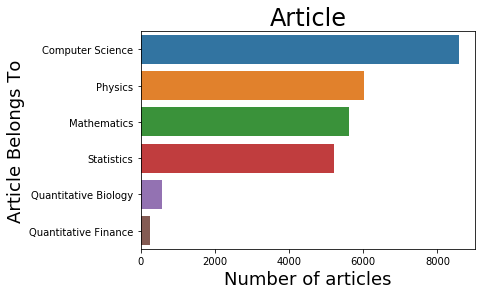

In [11]:
binary_labels=train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]
categories = list(binary_labels.columns.values)
ax= sns.barplot(binary_labels.sum().values, categories)

plt.title("Article", fontsize=24)
plt.ylabel('Article Belongs To', fontsize=18)
plt.xlabel('Number of articles', fontsize=18)
#adding the text labels
rects = ax.patches
labels = binary_labels.sum().values
plt.show()

### Plotting the label wise comments abstract

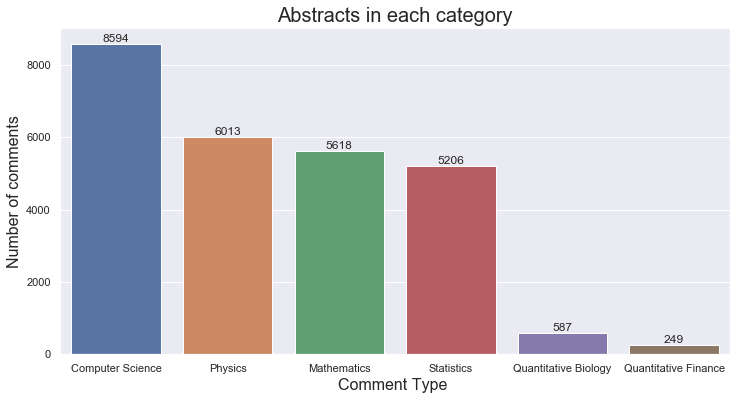

In [12]:
sns.set(font_scale = 1)
plt.figure(figsize=(12,6))

ax = sns.barplot(categories, train.iloc[:,3:].sum().values)

plt.title("Abstracts in each category", fontsize=20)
plt.ylabel('Number of comments', fontsize=16)
plt.xlabel('Comment Type ', fontsize=16)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show();

### Calculating number of comments having multiple labels

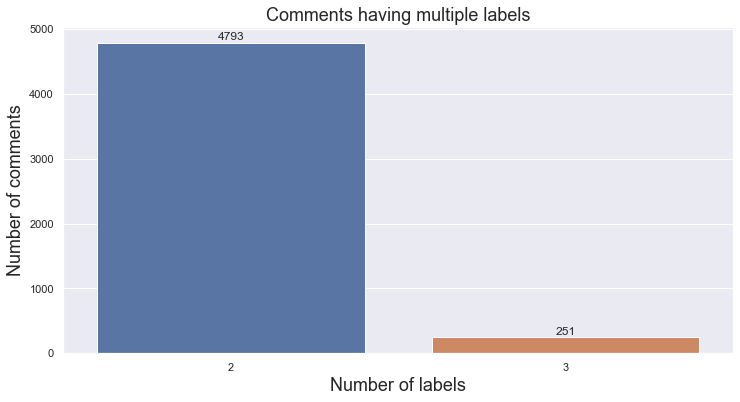

In [13]:
rowSums = train.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 1)
plt.figure(figsize=(12,6))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show();

# Text Data Cleaning

In [14]:
# Load stopwords, common words such as  "a," "the," "it," etc.
stop_words = stopwords.words('english')
    
#Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Removes non-alphabetical characters, whitespaces, and converts all letters to lowercase
def clean_text(txt): 
    txt= txt.lower()   #lowercase
    txt= re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt= word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
    
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem=w
            clean_text = clean_text + stem +" " 
    return clean_text


# Train data
train['TITLE']=train['TITLE'].apply(clean_text)
train['ABSTRACT']=train['ABSTRACT'].apply(clean_text)

# Test data
test['TITLE']=test['TITLE'].apply(clean_text)
test['ABSTRACT']=test['ABSTRACT'].apply(clean_text)

# Combining both features
train['combine']=train['TITLE']+train['ABSTRACT']
test['combine']=test['TITLE']+test['ABSTRACT']

### WordCloud representation of most used words in each category of comments

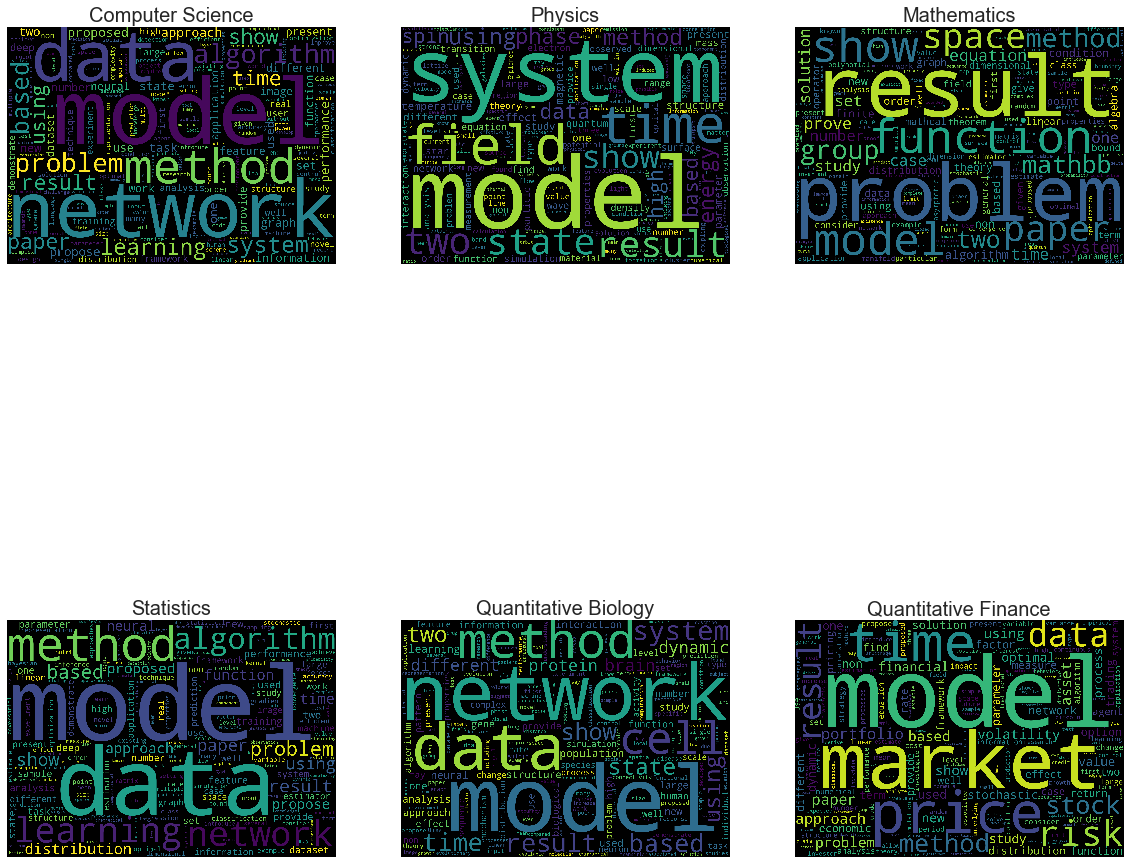

In [15]:
plt.figure(figsize=(20,20))

# Computer Science
subset = train[train['Computer Science']==1]

text = subset.ABSTRACT.values

cloud_computer_science = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                                  ).generate(" ".join(text))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('Computer Science',fontsize=20)
plt.imshow(cloud_computer_science)

# Physics
subset = train[train['Physics']==1]

text = subset.ABSTRACT.values

cloud_Physics = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                         ).generate(" ".join(text))

plt.subplot(2,3,2)
plt.axis('off')
plt.title('Physics',fontsize=20)
plt.imshow(cloud_Physics)

# Mathematics
subset = train[train['Mathematics']==1]

text = subset.ABSTRACT.values

cloud_Maths = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                         ).generate(" ".join(text))

plt.subplot(2,3,3)
plt.axis('off')
plt.title('Mathematics',fontsize=20)
plt.imshow(cloud_Maths)

# Statistics
subset = train[train['Statistics']==1]

text = subset.ABSTRACT.values

cloud_stats = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,4)
plt.axis('off')
plt.title('Statistics',fontsize=20)
plt.imshow(cloud_stats)

# Quantitative Biology
subset = train[train['Quantitative Biology']==1]

text = subset.ABSTRACT.values

cloud_quant_bio = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,5)
plt.axis('off')
plt.title('Quantitative Biology',fontsize=20)
plt.imshow(cloud_quant_bio)

# Quantitative Finance
subset = train[train['Quantitative Finance']==1]

text = subset.ABSTRACT.values

cloud_quant_Fin = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,6)
plt.axis('off')
plt.title('Quantitative Finance',fontsize=20)
plt.imshow(cloud_quant_Fin)

plt.show()

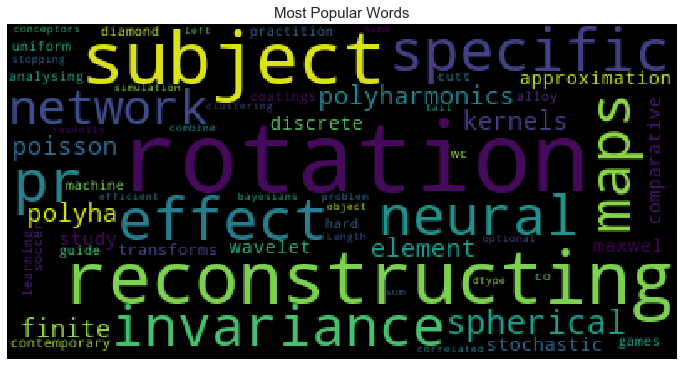

In [16]:
wordcloud = WordCloud(background_color = 'black').generate(str(train['combine']))
plt.rcParams['figure.figsize'] = (12, 8)
print(wordcloud)
plt.imshow(wordcloud)
plt.title('Most Popular Words', fontsize = 15)
plt.axis('off')
plt.show()

# Train and Validation split

In [17]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(train['combine'], binary_labels, test_size=0.2, random_state=9)

# TF-IDF Vectorizer


In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9999999999999999,min_df=0.0, ngram_range=(1, 3),max_features=45000)

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Model Building

In [19]:
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')

#Run SGDClassifier
sgd_classifier = OneVsRestClassifier(sgd)

# fit model on train data
sgd_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
yval_pred = sgd_classifier.predict(xval_tfidf)



print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score validation:  0.8337092844897591


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.82      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.43      0.57      0.49       116
Quantitative Finance       0.63      0.84      0.72        44

           micro avg       0.79      0.88      0.83      5233
           macro avg       0.71      0.83      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.91      0.85      5233



# Bagging Classifier

SGDClassifier Bagged

In [20]:
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')

sgd_bag=BaggingClassifier(base_estimator=sgd,random_state=9,n_jobs=-1)
sgd_bag_classifier = OneVsRestClassifier(sgd_bag)

# fit model on train data
sgd_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
yval_pred = sgd_bag_classifier.predict(xval_tfidf)

print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score validation:  0.835239852398524


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.90      0.86      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.80      0.86      0.83      1089
          Statistics       0.75      0.85      0.80      1069
Quantitative Biology       0.45      0.51      0.48       116
Quantitative Finance       0.62      0.80      0.70        44

           micro avg       0.81      0.87      0.84      5233
           macro avg       0.73      0.80      0.76      5233
        weighted avg       0.81      0.87      0.84      5233
         samples avg       0.84      0.89      0.85      5233



# Final Submition

In [21]:
X= train['combine']
X_test= test['combine']
y=binary_labels

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
X = tfidf_vectorizer.fit_transform(X)
X_test = tfidf_vectorizer.transform(X_test)

In [22]:
sgd_bag_classifier.fit(X,y)
y_pred = sgd_bag_classifier.predict(X_test)

col=['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
submit_test = pd.concat([test['ID'],pd.DataFrame(y_pred)], axis=1)
submit_test.columns=col
submit_test.to_csv('sample_submission.csv', index=False)
submit_test


,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,1,0,0,0
...,...,...,...,...,...,...,...
8984,29957,1,0,0,0,0,0
8985,29958,1,0,1,0,0,0
8986,29959,0,0,0,0,1,0
8987,29960,0,0,0,1,0,0
